In [24]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from data_read import *  

In [25]:
def calculate_four_conner_error(u_list_pre,v_list_pre,u_list_gt,v_list_gt):
    error=0.0
    for i in range(len(u_list_pre)):
        error=error+np.sqrt((u_list_pre[i]-u_list_gt[i])**2+(v_list_pre[i]-v_list_gt[i])**2)
    return error/4.0
    
    
def output_four_cornner(img_1,img_3):
    #img_1 is the satellite image
    #img_3 is the simulated drone image
    img_1=(img_1+1.0)/2.0*255.0
    img_3=(img_3+1.0)/2.0*255.0
    u_list=[]
    v_list=[]
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    img_1_8bit = cv2.normalize(img_1[:,:,:3], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    img_2_8bit = cv2.normalize(img_3[:,:,:3], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    img_1_8bit= cv2.cvtColor(img_1_8bit ,cv2.COLOR_RGB2GRAY)

    img_2_8bit= cv2.cvtColor(img_2_8bit ,cv2.COLOR_RGB2GRAY)


    kp1, des1 = sift.detectAndCompute(img_1_8bit,None)
    kp2, des2 = sift.detectAndCompute(img_2_8bit,None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    if len(np.shape(des1))<2 or len(np.shape(des2))<2:
        u_list=[1000,1000,1000,1000]
        v_list=[1000,1000,1000,1000]
        img_reverse=[1]
        
        return u_list,v_list, img_reverse
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    try:
        for m,n in matches:

            if m.distance < 0.75*n.distance:
                good.append([m])
    except:
        u_list=[1000,1000,1000,1000]
        v_list=[1000,1000,1000,1000]
        img_reverse=[1]
        return u_list,v_list, img_reverse
        
            
    h,w = img_2_8bit.shape[:2]

    MIN_MATCH_COUNT=3
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        if len(np.shape(M))<2:
            u_list=[1000,1000,1000,1000]
            v_list=[1000,1000,1000,1000]
            img_reverse=[1]
        
            return u_list,v_list, img_reverse
        matchesMask = mask.ravel().tolist()

        pts = np.float32([ [0,0],[w-1,0],[w-1,h-1],[0,h-1] ]).reshape(-1,1,2)
        try:
            dst = cv2.perspectiveTransform(pts,np.linalg.inv(M))
        except:
            u_list=[1000,1000,1000,1000]
            v_list=[1000,1000,1000,1000]
            img_reverse=[1]
            return u_list,v_list, img_reverse
        img_reverse = cv2.warpPerspective(img_2_8bit,np.linalg.inv(M),(w,h))
        dst=np.squeeze(dst)
        for j in range(4):
            u_list.append(dst[j,0])
            v_list.append(dst[j,1])
    else:
        u_list=[1000,1000,1000,1000]
        v_list=[1000,1000,1000,1000]
        img_reverse=[1]
        
    return u_list,v_list, img_reverse
       


In [26]:
data_loader=data_loader_MSCOCO('val')
total_lose=0
cornner_error_list_coco=[]

file = open("./SIFT_COCO.txt","w") 
count_sub=0
for i in range(6000):
    input_img,u_list_gt,v_list_gt,template_img=data_loader.data_read_batch(1)
    u_list_pre,v_list_pre, img_reverse=output_four_cornner(np.squeeze(input_img),np.squeeze(template_img))
    cornner_error=calculate_four_conner_error(u_list_pre,v_list_pre,np.squeeze(u_list_gt),np.squeeze(v_list_gt))
    print (cornner_error)
    if cornner_error<1.0:
        count_sub=count_sub+1
    print (i)
    print (count_sub/(i+1))
    cornner_error_list_coco.append(cornner_error)
    file.write(str(cornner_error))
    file.write('\n')


file.close()


6000
0.6987188779843088
0
1.0
1.1926909892961723
1
0.5
0.6897732013511328
2
0.6666666666666666
0.2108054488207151
3
0.75
0.5896594913205202
4
0.8
96.27459555544013
5
0.6666666666666666
0.4928306416081835
6
0.7142857142857143
0.558944285461642
7
0.75
1.1300015140385546
8
0.6666666666666666
1.2567025980625348
9
0.6
0.32481960162332657
10
0.6363636363636364
0.7087328628061493
11
0.6666666666666666
1.1890249555771395
12
0.6153846153846154
3.365603047509837
13
0.5714285714285714
2.9546888227072987
14
0.5333333333333333
0.4054674372390327
15
0.5625
1.3807852120601383
16
0.5294117647058824
0.7693168235497193
17
0.5555555555555556
0.508598138768968
18
0.5789473684210527
0.672092481385805
19
0.6
0.29944033706250295
20
0.6190476190476191
1.3487063880415673
21
0.5909090909090909
2.550410444996281
22
0.5652173913043478
0.27854930038123116
23
0.5833333333333334
0.2924305060094546
24
0.6
0.35798505951205317
25
0.6153846153846154
0.3395526423939387
26
0.6296296296296297
0.4842479735927252
27
0.642857

9.307431841162629
208
0.6220095693779905
0.4795388655494684
209
0.6238095238095238
0.7908503759115875
210
0.6255924170616114
1.3117500545879672
211
0.6226415094339622
7.007357993516477
212
0.6197183098591549
1.1497770008587906
213
0.616822429906542
0.7488980613141514
214
0.6186046511627907
1.701505884282535
215
0.6157407407407407
0.3310961993654924
216
0.6175115207373272
1.0187362908514754
217
0.6146788990825688
2.6686986527439673
218
0.6118721461187214
0.3629846662060131
219
0.6136363636363636
0.4851464990540133
220
0.6153846153846154
2.0687269057887674
221
0.6126126126126126
0.3588191465747209
222
0.6143497757847534
4.45459277223474
223
0.6116071428571429
1.368203113138824
224
0.6088888888888889
2.5490969007747672
225
0.6061946902654868
0.4964577592011449
226
0.6079295154185022
1.310202561005812
227
0.6052631578947368
0.7382845656477495
228
0.6069868995633187
0.4991643218327277
229
0.6086956521739131
2.6859569636530836
230
0.6060606060606061
0.4185387557911751
231
0.6077586206896551


0.5349758237961049
410
0.6423357664233577
0.5358335627002365
411
0.6432038834951457
0.19372701864699549
412
0.6440677966101694
0.33320123319425293
413
0.644927536231884
0.3786102254768098
414
0.6457831325301204
0.8774625557515556
415
0.6466346153846154
0.7896081452735689
416
0.6474820143884892
0.3603154751750308
417
0.6483253588516746
0.1752323711168174
418
0.649164677804296
0.5943740796557133
419
0.65
1.1948334481531617
420
0.6484560570071259
3.4776318082156155
421
0.6469194312796208
1.69922355159286
422
0.6453900709219859
0.4319427964207331
423
0.6462264150943396
0.378638478065616
424
0.6470588235294118
0.5553697380446809
425
0.647887323943662
0.7404002426730321
426
0.6487119437939111
0.25432010172262176
427
0.6495327102803738
0.16318374060463875
428
0.6503496503496503
1.0572008451463637
429
0.6488372093023256
0.518760852520527
430
0.6496519721577726
0.6011097708392464
431
0.6504629629629629
0.2506450503600973
432
0.651270207852194
1.1320237216131912
433
0.6497695852534562
0.32063253

0.8028718682081932
616
0.6418152350081038
0.5576189130305302
617
0.6423948220064725
0.28785925622197484
618
0.6429725363489499
0.5508155170171807
619
0.6435483870967742
0.3784123226457736
620
0.644122383252818
0.42558295142283886
621
0.6446945337620579
1.3496307885766043
622
0.6436597110754414
0.571856933527789
623
0.6442307692307693
1.3049249816839015
624
0.6432
1.5094396809742692
625
0.6421725239616614
0.6412210154466861
626
0.6427432216905901
0.21837876721842944
627
0.643312101910828
0.3605942734572462
628
0.643879173290938
0.6103091893508763
629
0.6444444444444445
0.1503963225171401
630
0.6450079239302694
1.1528118278692905
631
0.6439873417721519
1.1485698547962147
632
0.6429699842022117
0.3815298253270793
633
0.6435331230283912
0.3647083355214856
634
0.6440944881889764
40.96763801210708
635
0.6430817610062893
0.9118977263270983
636
0.6436420722135008
1.4459680208135568
637
0.6426332288401254
1.9777006317267065
638
0.6416275430359938
1.090067230829293
639
0.640625
0.709762884379244

2.3496971027002225
823
0.6359223300970874
1291.395641131132
824
0.6351515151515151
1.974597373032004
825
0.6343825665859564
0.537208095655207
826
0.6348246674727932
0.35546701033146366
827
0.6352657004830918
0.37239473766467207
828
0.6357056694813028
0.5864365595202152
829
0.636144578313253
0.4718508542743681
830
0.6365824308062575
0.5926645595876723
831
0.6370192307692307
0.5414873559266715
832
0.6374549819927972
3.2442197513977713
833
0.6366906474820144
0.7578988263747083
834
0.637125748502994
0.8051254026914301
835
0.6375598086124402
0.4810107955899508
836
0.6379928315412187
0.7903825324918493
837
0.6384248210023866
0.24512026937200543
838
0.6388557806912991
0.8670814128034181
839
0.6392857142857142
46.41354082482601
840
0.638525564803805
0.3434934378736473
841
0.6389548693586699
0.71243200997011
842
0.6393831553973903
0.823113870948532
843
0.6398104265402843
0.0774009767531894
844
0.6402366863905326
0.21609167628948678
845
0.640661938534279
0.96441946903436
846
0.641086186540732
0.

0.25950082949109854
1029
0.6436893203883495
0.9103990585036179
1030
0.6440349175557711
0.4451835839787305
1031
0.6443798449612403
1.0953839241886594
1032
0.643756050338819
0.38229829646649616
1033
0.6441005802707931
0.9594685578062521
1034
0.6444444444444445
72.08260520335959
1035
0.6438223938223938
0.2124347083501502
1036
0.6441658630665381
0.5729284004164727
1037
0.6445086705202312
0.8080429383660357
1038
0.6448508180943214
0.22698205577197067
1039
0.6451923076923077
1.0636107352680797
1040
0.6445725264169068
0.6224359726895636
1041
0.6449136276391555
2.8873909421336297
1042
0.6442953020134228
0.18881398913301142
1043
0.6446360153256705
0.33299261604299224
1044
0.6449760765550239
1.6661907542191834
1045
0.6443594646271511
0.46113388139505
1046
0.6446991404011462
0.5123022672929483
1047
0.6450381679389313
3.9433776122155555
1048
0.6444232602478551
0.6077947919999549
1049
0.6447619047619048
0.21400328046157946
1050
0.6450999048525214
0.412057083120612
1051
0.6454372623574145
0.58600032

0.1341404024850309
1225
0.6468189233278956
0.46450134961879375
1226
0.6471067644661777
0.8261083886372855
1227
0.6473941368078175
0.8143901672796983
1228
0.6476810414971521
0.5725074674683507
1229
0.6479674796747967
0.29232306627451804
1230
0.6482534524776604
0.4598742451645125
1231
0.648538961038961
1.4940217635149946
1232
0.6480129764801298
1283.4642903605286
1233
0.6474878444084279
0.5338227626444748
1234
0.6477732793522267
0.6317315842724447
1235
0.6480582524271845
1.2278227471884375
1236
0.6475343573160873
0.5632301665969374
1237
0.6478190630048465
10.636476661430068
1238
0.6472962066182405
0.5936121019894626
1239
0.6475806451612903
1.4568240986473098
1240
0.6470588235294118
0.5319450576347542
1241
0.6473429951690821
1.1882203524095116
1242
0.6468222043443282
0.48528223528170866
1243
0.6471061093247589
0.42738687019497934
1244
0.6473895582329318
1.478908441763406
1245
0.6468699839486356
0.17633659194457657
1246
0.6471531676022454
3.257939490126078
1247
0.6466346153846154
0.1843758

0.9135848094912777
1424
0.6449122807017544
0.7302035092256722
1425
0.6451612903225806
0.4315008598819617
1426
0.6454099509460406
1.2209325869969847
1427
0.6449579831932774
0.5152741101676918
1428
0.6452064380685795
3.6671472987835787
1429
0.6447552447552447
0.24315941481821973
1430
0.6450034940600978
0.5077196737473116
1431
0.6452513966480447
0.5438758617505127
1432
0.6454989532449407
0.225520628424215
1433
0.6457461645746164
1.0033139883619646
1434
0.6452961672473868
0.5825923956184318
1435
0.6455431754874652
3.912923741680424
1436
0.6450939457202505
0.7373231558889543
1437
0.6453407510431154
0.6139231660335707
1438
0.645587213342599
1279.3167970798108
1439
0.6451388888888889
2.209874499772176
1440
0.6446911866759195
99.44029528711862
1441
0.644244105409154
0.3872100731945422
1442
0.6444906444906445
0.36540193717400526
1443
0.6447368421052632
5.631097536493827
1444
0.6442906574394464
83.01397994154313
1445
0.6438450899031812
0.24963559341467803
1446
0.6440912232204561
20.1276987245876

2.336421534359338
1623
0.6490147783251231
0.45120811980586145
1624
0.6492307692307693
0.5651179920943
1625
0.6494464944649446
0.8501001876396522
1626
0.6496619545175168
0.5866654817012062
1627
0.6498771498771498
0.31629528569821086
1628
0.6500920810313076
3.1768788970160626
1629
0.6496932515337424
0.6371491094061169
1630
0.6499080318822809
0.4482479390599571
1631
0.6501225490196079
0.5877416733520553
1632
0.6503368034292712
5.925761133229468
1633
0.6499388004895961
0.4143178333427936
1634
0.6501529051987768
0.5660336601291975
1635
0.6503667481662592
0.0989635211341132
1636
0.6505803298717165
0.46413068467806023
1637
0.6507936507936508
0.1672690102019069
1638
0.6510067114093959
0.5436299853557569
1639
0.651219512195122
193.4389500937348
1640
0.6508226691042047
0.1123360346783561
1641
0.6510353227771011
1.3533425059945552
1642
0.6506390748630554
0.4672253764727425
1643
0.6508515815085159
0.48398111538729716
1644
0.6510638297872341
0.8851751585560899
1645
0.6512758201701093
0.823563956267

2.0791968590843384
1822
0.6489303346132749
0.9466266309382629
1823
0.6491228070175439
0.3605824340432788
1824
0.6493150684931507
0.8758141227559596
1825
0.6495071193866374
1.5601603551624694
1826
0.6491516146688561
2.1824535635958426
1827
0.6487964989059081
8.585547873161385
1828
0.6484417714598141
1.5920839349734275
1829
0.6480874316939891
0.14122354854243055
1830
0.6482796286182414
1.0204837822401585
1831
0.6479257641921398
0.4715879034500142
1832
0.6481178396072013
0.3708529405708283
1833
0.6483097055616139
1.0533256695122235
1834
0.6479564032697548
0.5887557007749105
1835
0.6481481481481481
0.38588045408356836
1836
0.648339684267828
3.5757963177525216
1837
0.6479869423286181
6.967424848848559
1838
0.6476345840130505
0.670445624159984
1839
0.6478260869565218
0.3559442031731032
1840
0.6480173818576861
0.3631581511578872
1841
0.6482084690553745
0.711260914096016
1842
0.6483993488876831
0.49106808733506
1843
0.648590021691974
0.1116317743560282
1844
0.6487804878048781
0.544293430849935

0.6356231153862595
2014
0.6511166253101737
1.3199828776194518
2015
0.6507936507936508
1.0732785238097102
2016
0.6504709965294992
0.24238815292924776
2017
0.6506442021803767
0.2241013914962535
2018
0.6508172362555721
0.4539804997904322
2019
0.650990099009901
0.2556858580978482
2020
0.6511627906976745
0.5990601079378062
2021
0.6513353115727003
0.7525616633660374
2022
0.6515076618882847
0.6535482954210841
2023
0.6516798418972332
0.5198942277810308
2024
0.6518518518518519
1.0875158848701985
2025
0.6515301085883515
0.8468636924082036
2026
0.6517020226936359
188.9531464303789
2027
0.6513806706114399
13.355535893489566
2028
0.6510596352883193
12.409744966050589
2029
0.6507389162561577
0.9227722575151762
2030
0.6509108813392418
0.8757308621080326
2031
0.6510826771653543
0.37101946168288125
2032
0.6512543039842598
1.5823703283297412
2033
0.6509341199606686
0.7918265692965263
2034
0.6511056511056511
0.3118351275793623
2035
0.6512770137524558
0.47345094120146375
2036
0.6514482081492391
0.34815993

0.44581154843971993
2209
0.6592760180995475
0.6292601590783901
2210
0.6594301221166893
80.91167006178846
2211
0.659132007233273
0.7841274515190588
2212
0.6592860370537732
1.0497284563648166
2213
0.6589882565492322
0.7598262354968702
2214
0.6591422121896162
9.797222686249654
2215
0.6588447653429603
1.3314766064761148
2216
0.6585475868290482
0.8820624870546611
2217
0.6587015329125339
0.3507386695025473
2218
0.6588553402433529
0.27821585478202626
2219
0.659009009009009
0.41675961593640304
2220
0.6591625393966681
0.6093985205858958
2221
0.6593159315931593
0.6696310675129764
2222
0.6594691857849753
84.75956818190276
2223
0.6591726618705036
0.27505310588130183
2224
0.6593258426966292
10.05843724594773
2225
0.6590296495956873
0.9894627766031268
2226
0.6591827570722946
0.8034023133333876
2227
0.6593357271095153
0.306849603205702
2228
0.6594885598923284
0.4830704366280021
2229
0.6596412556053811
0.1028986966889647
2230
0.6597938144329897
0.4813968369315894
2231
0.6599462365591398
0.239312878898

0.9966927339917873
2411
0.6575456053067993
0.38339727167902926
2412
0.6576875259013676
0.6446167944133939
2413
0.6578293289146645
0.24417911431440426
2414
0.6579710144927536
0.7198068149663756
2415
0.6581125827814569
312.2488791881482
2416
0.6578402978899462
0.3195496259967962
2417
0.6579818031430935
0.4071096286263179
2418
0.6581231914014055
1273.953935542375
2419
0.6578512396694215
1.543906905002606
2420
0.6575795125981
0.5264834580194842
2421
0.6577208918249381
0.5167180111959144
2422
0.6578621543541064
3.440334169531903
2423
0.6575907590759076
0.759816345681647
2424
0.6577319587628866
125.51112719473831
2425
0.6574608408903545
0.5276436612664325
2426
0.657601977750309
1.2528198069414518
2427
0.657331136738056
0.2732500685946004
2428
0.6574722107863318
21.548108707239265
2429
0.657201646090535
0.4059513844622628
2430
0.6573426573426573
1.1776989708590149
2431
0.6570723684210527
0.601339428732609
2432
0.657213316892725
1.4640520738329943
2433
0.6569433032046015
65.54697910192648
2434

0.41379843977453107
2608
0.6604062859333077
0.8075981166316486
2609
0.660536398467433
35.31843382419048
2610
0.6602834163155878
1.4221882256072877
2611
0.6600306278713629
0.7092988113552451
2612
0.6601607347876005
0.35531239013090676
2613
0.6602907421576129
1.8598673388934632
2614
0.6600382409177821
23.7948019206544
2615
0.6597859327217125
0.41880712500499817
2616
0.6599159342758885
1.2087025400424345
2617
0.6596638655462185
0.8200252013018265
2618
0.6597938144329897
2.988131400752645
2619
0.6595419847328244
0.5527397447323295
2620
0.6596718809614651
0.4574131454357438
2621
0.6598016781083142
0.30651682188280227
2622
0.6599313762866946
0.720353793097203
2623
0.6600609756097561
0.6633857662283524
2624
0.6601904761904762
2.5047635762195046
2625
0.6599390708301599
1.7378738665634297
2626
0.6596878568709554
3.1164534678387446
2627
0.6594368340943684
0.5277757818527016
2628
0.6595663750475466
0.9702904637739145
2629
0.6596958174904943
1275.8079517259628
2630
0.6594450779171418
0.24644238800

0.49161267523879276
2805
0.6625089094796864
1.894773656027004
2806
0.6622728892055575
0.3766528735201454
2807
0.6623931623931624
0.20051713895257123
2808
0.6625133499466002
3.8241960866249034
2809
0.6622775800711744
0.32300128145524937
2810
0.6623977232301672
0.6914055681578425
2811
0.6625177809388336
0.5301307765485558
2812
0.6626377532883043
0.3230059470567368
2813
0.6627576403695806
3.401270768914696
2814
0.6625222024866785
0.25125651724818543
2815
0.6626420454545454
0.6447008186976743
2816
0.6627618033368832
0.46928442159063716
2817
0.6628814762242725
120.42462872708623
2818
0.6626463284852785
1.0782803313479588
2819
0.6624113475177305
3.449607543335771
2820
0.662176533144275
0.2820344513066491
2821
0.6622962437987243
0.5488242423502118
2822
0.6624158696422245
0.49026418407304184
2823
0.6625354107648725
2.19215988624778
2824
0.6623008849557522
91.58990014111623
2825
0.66206652512385
1.0030236235299834
2826
0.6618323310930315
0.538205010655407
2827
0.6619519094766619
4.8255425085372

0.6475034395038148
3001
0.6608927381745503
1.743866070131105
3002
0.6606726606726607
0.4510736895570603
3003
0.6607856191744341
0.893943480421197
3004
0.6608985024958403
0.39901872712690256
3005
0.6610113107119095
0.2794840800153802
3006
0.6611240438975723
0.26348260832405246
3007
0.6612367021276596
0.13908979779002678
3008
0.6613492854769026
80.07169747068458
3009
0.6611295681063123
0.2807760331575586
3010
0.6612421122550648
0.35690321396540664
3011
0.6613545816733067
0.33844095756237436
3012
0.6614669764354464
3.8484073686291436
3013
0.6612475116124751
0.47014793376385816
3014
0.6613598673300166
0.3560851323850497
3015
0.661472148541114
0.19633440801374596
3016
0.6615843553198542
1.1001271430966764
3017
0.6613651424784626
3.8328156009919425
3018
0.6611460748592249
1.2484746387993888
3019
0.6609271523178808
0.8679628246707225
3020
0.6610393909301556
0.35665344644520774
3021
0.6611515552614163
0.683910308471825
3022
0.6612636453853787
0.3440793977853457
3023
0.6613756613756614
0.313611

0.4315725294310426
3202
0.6609428660630658
1.2412700168087059
3203
0.6607365792759051
0.8874041818156542
3204
0.6608424336973479
1.1512441448190402
3205
0.6606363069245166
0.642831357588406
3206
0.6607421265980667
2.074459189862481
3207
0.6605361596009975
0.24627527091218362
3208
0.6606419445310066
1.0167042373034456
3209
0.660436137071651
107.29699859123856
3210
0.660230457801308
0.4229067365975294
3211
0.6603362391033624
0.21986991956269497
3212
0.6604419545596016
0.8705253976254188
3213
0.6605476042314873
3.1021375637650497
3214
0.6603421461897356
2.4315830812418313
3215
0.660136815920398
9.111512637052611
3216
0.6599316133043208
2.7154058162036825
3217
0.6597265382224985
0.621056499880052
3218
0.6598322460391426
0.31151787517428753
3219
0.6599378881987578
0.8039802452351557
3220
0.6600434647624961
30.09386390451048
3221
0.65983860955928
0.8741606050057038
3222
0.6599441514117282
1.096149250853018
3223
0.6597394540942928
0.30625485777896844
3224
0.6598449612403101
1.1413890948494472

0.39049154999689456
3403
0.6589306698002351
0.7163628794957286
3404
0.6590308370044052
2.2232453226856643
3405
0.6588373458602467
0.31827843402226125
3406
0.6589374816554153
0.29263052710790066
3407
0.659037558685446
0.8504815330473434
3408
0.6591375770020534
0.46366066445425824
3409
0.6592375366568914
0.9124035031261774
3410
0.6593374377015538
0.4702719769683239
3411
0.6594372801875733
4.587495478415124
3412
0.6592440668033988
0.34909194183144915
3413
0.659343878148799
0.5927973421034938
3414
0.6594436310395315
0.28707422764947477
3415
0.6595433255269321
0.9364822882657675
3416
0.6596429616622769
0.8872065088624331
3417
0.6597425394967817
0.5002693902412507
3418
0.6598420590816028
0.47638704346871097
3419
0.6599415204678363
0.234639452681827
3420
0.6600409237065186
0.4731697019972149
3421
0.6601402688486265
0.25828109788581827
3422
0.6602395559450774
78.93692586966806
3423
0.6600467289719626
0.7368491234262599
3424
0.6601459854014599
0.18265382656303075
3425
0.660245183887916
5.285470

0.36483610275637696
3596
0.6591604114539894
0.5125086773465415
3597
0.6592551417454141
0.5529117310740452
3598
0.6593498193942762
0.13534762422351376
3599
0.6594444444444445
1.2374500099352836
3600
0.6592613163010275
0.2653261412586844
3601
0.6593559133814547
0.645318866422099
3602
0.6594504579517069
0.8376873933497653
3603
0.6595449500554939
0.8315716789604869
3604
0.6596393897364771
0.3550809567611594
3605
0.6597337770382695
0.7028102253735832
3606
0.6598281120044358
0.45400013844932985
3607
0.6599223946784922
1.327218968514417
3608
0.6597395400387919
0.24701605388662248
3609
0.6598337950138504
2.038230813987134
3610
0.6596510661866519
0.17642300281467044
3611
0.6597452934662237
0.3213651330380362
3612
0.6598394685856629
26.30094385943164
3613
0.6596568898727172
0.7830584058249088
3614
0.6597510373443983
2.572513016266061
3615
0.6595685840707964
1.0313267170229452
3616
0.6593862316837158
1.4915800987558234
3617
0.6592039800995025
5.306025005142969
3618
0.6590218292345952
0.4243700683

1.1364214042730822
3794
0.661133069828722
0.5979835353712578
3795
0.6612223393045311
0.5253960145307524
3796
0.6613115617592836
0.3059804130228066
3797
0.6614007372301212
0.5493352234803509
3798
0.6614898657541458
0.45173512610207606
3799
0.661578947368421
0.7804768334221086
3800
0.661667982109971
0.8937182167713251
3801
0.6617569700157812
1.0783434384672597
3802
0.6615829608204049
1.412619532156096
3803
0.6614090431125131
0.33343241833265236
3804
0.6614980289093298
0.4246491077550496
3805
0.6615869679453494
0.35565849887613343
3806
0.6616758602574205
0.5338443926529487
3807
0.6617647058823529
1279.2439365755167
3808
0.6615909687582042
0.39780625465491243
3809
0.6616797900262468
0.14873676476858377
3810
0.6617685646811861
0.38252777322101866
3811
0.6618572927597062
0.31591082262039927
3812
0.6619459742984527
0.8669934572225109
3813
0.6620346093340325
0.3272571873423115
3814
0.6621231979030144
2.0894353283633254
3815
0.6619496855345912
0.4132856895208388
3816
0.6620382499345036
0.334099

0.6387414904922661
3986
0.6593930273388513
3.527276232817876
3987
0.6592276830491475
1.1770328444303555
3988
0.6590624216595637
0.26414426051852435
3989
0.6591478696741855
0.30215078222428693
3990
0.6592332748684541
3.8017331119065236
3991
0.6590681362725451
0.4044940458967476
3992
0.6591535186576509
0.6406101003373345
3993
0.6592388582874311
0.30660443853530706
3994
0.6593241551939925
0.6871367452338394
3995
0.6594094094094094
1.408492327231614
3996
0.6592444333249937
2.59377414463456
3997
0.659079539769885
0.3912161628371435
3998
0.6591647911977995
0.8320981775358122
3999
0.65925
0.6280672655062794
4000
0.6593351662084479
0.23239809015363708
4001
0.6594202898550725
0.3276113542286162
4002
0.6595053709717712
1.0260637558799015
4003
0.6593406593406593
0.753340237334669
4004
0.6594257178526841
0.258454736567014
4005
0.6595107338991513
0.9025103581401838
4006
0.6595957075118543
0.6729479572756478
4007
0.6596806387225549
0.4756204121203956
4008
0.6597655275629832
1293.482317652276
4009
0.

1.0323336483707892
4179
0.6588516746411484
0.2882972912183896
4180
0.6589332695527386
0.3810750444837264
4181
0.6590148254423721
0.5823325864914014
4182
0.6590963423380349
0.16869693952435583
4183
0.6591778202676865
6.67351901107631
4184
0.6590203106332139
0.8251865693287921
4185
0.65910176779742
0.45159588945152224
4186
0.6591831860520659
0.46242032970434166
4187
0.6592645654250239
2.118817223761425
4188
0.6591071854857962
6.533714648960693
4189
0.6589498806682578
0.7920698827564423
4190
0.6590312574564543
0.7325263404084157
4191
0.6591125954198473
3.6680968868213046
4192
0.6589554018602433
0.8326753970046507
4193
0.659036719122556
0.21082368840241367
4194
0.6591179976162098
0.5041118836522731
4195
0.6591992373689228
0.6422251289045189
4196
0.6592804384083869
4.232664935056551
4197
0.6591233920914721
2.162415725759791
4198
0.6589664205763277
0.3023206091040352
4199
0.659047619047619
0.9614436213935511
4200
0.6591287788621757
2.619807616398414
4201
0.6589719181342218
0.5971609249242884

1.428885667311523
4371
0.659423604757548
1.7628272215378304
4372
0.6592728104276241
0.8957081974804731
4373
0.6593507087334248
0.9805871816240219
4374
0.6594285714285715
1.0996006128911033
4375
0.6592778793418648
6.087886784984162
4376
0.6591272561114919
0.5298117862420679
4377
0.6592051164915487
0.4416853665758142
4378
0.6592829413108016
0.348426070587655
4379
0.6593607305936073
0.1615979405733166
4380
0.6594384843643004
0.854643559192378
4381
0.659516202647193
2.2107447144675927
4382
0.6593657312343144
0.19244356303771692
4383
0.6594434306569343
0.6767198428991537
4384
0.659521094640821
0.8323679342529492
4385
0.6595987232102143
0.3671862886590401
4386
0.6596763163893321
1.103744828974326
4387
0.6595259799453054
1.3928835903001229
4388
0.659375712007291
0.45753618952416564
4389
0.6594533029612756
0.3421894363788289
4390
0.6595308585743567
0.6192353450773631
4391
0.6596083788706739
0.12849767347976543
4392
0.6596858638743456
2.108847981625875
4393
0.6595357305416477
2.55653062433653
4

0.26434063164545274
4565
0.6618484450284713
0.6376148546894796
4566
0.6619224874096781
0.2041513658049762
4567
0.6619964973730298
0.33997062480112644
4568
0.6620704749398117
1.1932530658437328
4569
0.661925601750547
0.4816483415028367
4570
0.6619995624589805
0.9774229738838611
4571
0.6620734908136483
1.0647458385527975
4572
0.6619287120052482
0.7873061782833275
4573
0.6620026235242676
0.47897853721068695
4574
0.6620765027322404
0.9668135557100299
4575
0.6621503496503497
0.2832678654654003
4576
0.6622241642997597
0.42813741449215076
4577
0.6622979467016165
5.770607705663399
4578
0.66215330858266
4.873790040501155
4579
0.6620087336244541
0.3214947076318786
4580
0.6620825147347741
0.8816435616473173
4581
0.6621562636403318
1.7855063926396615
4582
0.6620117826751036
0.3726244855505818
4583
0.662085514834206
83.61974362220444
4584
0.6619411123227917
0.7188169484593291
4585
0.6620148277365896
0.37340606439495194
4586
0.6620885110093743
3.887342073452734
4587
0.661944202266783
0.2814706489880

0.23110958675714466
4760
0.6626759084226003
0.7771920493298442
4761
0.6627467450650987
2.1851016765039555
4762
0.6626076002519421
0.2215264483384926
4763
0.6626784214945424
0.937274310207893
4764
0.6627492130115425
0.9960778985293146
4765
0.6628199748216533
2.7958207174077554
4766
0.6626809314033983
3.131075168807938
4767
0.6625419463087249
0.28015023402580513
4768
0.6626127070664709
0.2669338457787874
4769
0.6626834381551363
0.4622090291567773
4770
0.6627541395933767
0.13515563916507733
4771
0.6628248113998324
0.2623704504054594
4772
0.662895453593128
0.8702782831530507
4773
0.6629660661918726
0.8212577909097161
4774
0.6630366492146597
9.478251396671501
4775
0.6628978224455612
0.41306312577101956
4776
0.6629683902030563
0.6089164009694907
4777
0.6630389284219339
0.17394221322995243
4778
0.6631094371207366
0.16915352349760845
4779
0.6631799163179917
66.1147098533675
4780
0.6630412047688768
0.30626999702130797
4781
0.6631116687578419
0.3813834742968692
4782
0.6631821032824587
0.34055609

0.29095201346361577
4956
0.6637078878353843
0.9818579084677446
4957
0.663775716014522
0.45114757659664273
4958
0.6638435168380722
2.1318722633481366
4959
0.6637096774193548
0.33884922403580786
4960
0.6637774642209232
0.9866709384977529
4961
0.6638452237001209
0.3683678729261044
4962
0.6639129558734637
112.92045589514771
4963
0.6637792103142627
0.44314897508425305
4964
0.6638469284994964
1.0771912557607761
4965
0.6637132501006846
1.2846957028552335
4966
0.663579625528488
0.590493067682092
4967
0.663647342995169
0.4947404911443341
4968
0.6637150332058764
0.5756688951201239
4969
0.6637826961770624
0.6351219513052868
4970
0.663850331925166
0.8487432975084712
4971
0.663917940466613
0.3064611561847627
4972
0.6639855218178162
0.5433943724745363
4973
0.6640530759951749
0.5311797315679663
4974
0.6641206030150754
0.6481492919834818
4975
0.6641881028938906
0.5905974724834379
4976
0.6642555756479807
2.6256589844957503
4977
0.6641221374045801
1.9506192789479915
4978
0.6639887527615987
2.14343668420

0.5465219713489265
5149
0.6675728155339806
1.1154697205355848
5150
0.6674432149097262
0.7552734048624473
5151
0.6675077639751553
2.16134413937912
5152
0.6673782262759558
0.48755561979641904
5153
0.6674427629026
0.25142636332365437
5154
0.6675072744907856
0.5396860334651741
5155
0.6675717610550814
1.6856251681798415
5156
0.667442311421369
1.6930298327620734
5157
0.6673129119813881
0.36332381315401713
5158
0.6673773987206824
1.0069746058424407
5159
0.6672480620155039
0.2926262357765088
5160
0.6673125363301686
201.79556915292866
5161
0.6671832623014335
0.6325866165809506
5162
0.6672477241913616
0.611295129837643
5163
0.6673121611154144
0.5547483761164619
5164
0.667376573088093
1.032551490132474
5165
0.6672473867595818
30.189805862968644
5166
0.6671182504354558
0.3360662231504961
5167
0.6671826625386997
0.3365544887359795
5168
0.6672470497194816
0.20008062179608155
5169
0.6673114119922631
2.5356176968686297
5170
0.667182363179269
0.265591690912909
5171
0.667246713070379
0.42069968378651873

0.4542826571921682
5341
0.667353051291651
0.2151072785864094
5342
0.6674153097510762
1.7300439051743821
5343
0.6672904191616766
0.8684845070687677
5344
0.6673526660430309
1.7098187228495876
5345
0.6672278338945006
0.6397350652399578
5346
0.667290069197681
0.23544125390024048
5347
0.6673522812266268
1297.4652671674717
5348
0.6672275191624603
0.7805676314202052
5349
0.6672897196261682
0.6149746875640622
5350
0.6673518968417118
2.7569497259309044
5351
0.6672272047832586
0.800572414755321
5352
0.6672893704464786
0.22554658791361726
5353
0.6673515128875607
0.8232092609453014
5354
0.6674136321195144
1.3541774269283147
5355
0.6672890216579537
1.4581380871757084
5356
0.6671644577188725
1.2368247497233247
5357
0.6670399402762225
0.2763795536837431
5358
0.6671020712819556
0.5327647295173508
5359
0.6671641791044776
0.5593561493017788
5360
0.6672262637567618
0.09888712181806104
5361
0.6672883252517717
1.034809938554841
5362
0.66716390080179
0.4378891412232254
5363
0.6672259507829977
0.627368547971

0.4458801978100855
5532
0.6678113139345744
0.7057677817681497
5533
0.667871340802313
0.8622048846353922
5534
0.6679313459801265
0.4767209017657825
5535
0.6679913294797688
0.34588698105151816
5536
0.6680512913129854
0.8956138631689046
5537
0.6681112314915132
2.1885595092198415
5538
0.667990612023831
0.5483485418112145
5539
0.6680505415162454
3.5861631536796237
5540
0.6679299765385309
0.8570655066966766
5541
0.6679898953446409
2.0032583536508755
5542
0.6678693848096698
0.559961457194501
5543
0.6679292929292929
0.20856023747529812
5544
0.6679891794409378
0.19391194506948423
5545
0.6680490443562929
12.027871053424848
5546
0.6679286100594917
180.63591302110734
5547
0.6678082191780822
0.15534595206760865
5548
0.6678680843395206
0.7205345889976831
5549
0.6679279279279279
0.2882723373200936
5550
0.667987749954963
0.8053772823531276
5551
0.6680475504322767
0.636988871815317
5552
0.6681073293715108
0.6729007203048536
5553
0.6681670867842996
0.2492260270356981
5554
0.6682268226822682
0.4616471611

0.41796927291074903
5724
0.6681222707423581
82.44643985384148
5725
0.6680055885434859
1.81699670363815
5726
0.6678889470927187
353.85183495727193
5727
0.6677723463687151
0.5422603471074152
5728
0.6678303368825275
2.898068946756724
5729
0.6677137870855149
2.0128560785364162
5730
0.6675972779619612
0.3372527778284496
5731
0.6676552686671319
0.41485437848194123
5732
0.6677132391418106
671.9684048373932
5733
0.6675967910708057
0.36512445097568735
5734
0.6676547515257193
1.272007261801764
5735
0.6675383542538355
0.8418970947542502
5736
0.6675963046888618
8.044211526119064
5737
0.6674799581735796
0.6128084231164808
5738
0.6675378985886042
1.9698569363258585
5739
0.6674216027874564
0.18612793330229974
5740
0.6674795331823724
0.4252276891335718
5741
0.6675374433995124
0.9937275707244719
5742
0.6675953334494167
0.26388335063312945
5743
0.6676532033426184
499.2394998554286
5744
0.6675369886858138
2.031464929418943
5745
0.667420814479638
0.5442651028925469
5746
0.6674786845310596
1292.83707779729

0.4170248018348888
5921
0.6673421141506248
0.24750965682348802
5922
0.667398277899713
0.39962728639363493
5923
0.6674544226873734
0.16432435203746948
5924
0.6675105485232068
0.6263487947330404
5925
0.6675666554168073
1.704527431054218
5926
0.6674540239581576
103.75806248298318
5927
0.6673414304993253
1.1483637181167892
5928
0.6672288750210829
0.7510655852324453
5929
0.6672849915682968
2.33057841623461
5930
0.6671724835609509
0.5221324876716871
5931
0.6672285906945381
6.007845622710258
5932
0.6671161301196696
0.945876884049793
5933
0.6671722278395685
1.0337651448235592
5934
0.6670598146588037
0.7938129215454172
5935
0.6671159029649596
0.29773610747429224
5936
0.6671719723766212
1.524791420085592
5937
0.6670596160323341
0.39564526370176045
5938
0.6671156760397373
3.3723388671848102
5939
0.667003367003367
0.678598945887213
5940
0.6670594176064636
0.15100674261057112
5941
0.6671154493436553
1.5180375287964818
5942
0.6670031970385327
3.4797502413802617
5943
0.6668909825033648
0.590687737709

IndexError: invalid index to scalar variable.

In [27]:
data_loader=data_loader_GoogleMap('val')
total_lose=0
cornner_error_list_rs=[]

file = open("./SIFT_GoogleMap.txt","w") 
count_sub=0
for i in range(2000):
    print (i)
    input_img,u_list_gt,v_list_gt,template_img=data_loader.data_read_batch(1)
    u_list_pre,v_list_pre, img_reverse=output_four_cornner(np.squeeze(input_img),np.squeeze(template_img))
    cornner_error=calculate_four_conner_error(u_list_pre,v_list_pre,np.squeeze(u_list_gt),np.squeeze(v_list_gt))
    print (cornner_error)
    if cornner_error<1.0:
        count_sub=count_sub+1
    print (i)
    print (count_sub/(i+1))
    cornner_error_list_rs.append(cornner_error)
    file.write(str(cornner_error))
    file.write('\n')


file.close()




888
0
1298.1854485734625
0
0.0
1
1270.545430593905
1
0.0
2
1282.8249551116146
2
0.0
3
1280.8163584228791
3
0.0
4
1279.7444165696359
4
0.0
5
115.97569461733056
5
0.0
6
1286.811110651953
6
0.0
7
1267.6436440694547
7
0.0
8
1281.953413816522
8
0.0
9
1276.1408034752621
9
0.0
10
1280.9664329063366
10
0.0
11
1284.2099297481975
11
0.0
12
1291.3637152970064
12
0.0
13
1292.405155133661
13
0.0
14
1283.480356413748
14
0.0
15
1284.091593092809
15
0.0
16
1291.2643270580638
16
0.0
17
1273.7253146113223
17
0.0
18
1285.5894699969956
18
0.0
19
1279.851679016734
19
0.0
20
124.21818558219039
20
0.0
21
1277.8736331205791
21
0.0
22
1280.6670392982137
22
0.0
23
1309.8219974244653
23
0.0
24
1287.6065676043072
24
0.0
25
1281.7212320495964
25
0.0
26
131.26085090532885
26
0.0
27
103.89625607168037
27
0.0
28
1278.0299281876798
28
0.0
29
1287.3687140002926
29
0.0
30
1280.7629046923562
30
0.0
31
1285.0940205234906
31
0.0
32
148.06226770573596
32
0.0
33
1285.0723581872055
33
0.0
34
1277.47769865301
34
0.0
35
1283.15

1269.7458336238278
276
0.0
277
1285.143266364302
277
0.0
278
114.7125351628319
278
0.0
279
1278.7773506136548
279
0.0
280
1278.6622332451382
280
0.0
281
1284.7028846615945
281
0.0
282
1291.234063042225
282
0.0
283
1286.471453101085
283
0.0
284
1276.3243285910532
284
0.0
285
1297.7934413899238
285
0.0
286
651.6963256158839
286
0.0
287
1281.6174208034915
287
0.0
288
1279.4772769260253
288
0.0
289
1279.472453875949
289
0.0
290
1259.9484126406662
290
0.0
291
1286.5888195974626
291
0.0
292
1276.2540531634206
292
0.0
293
2730.8344421875727
293
0.0
294
1290.898135829197
294
0.0
295
1277.622256845625
295
0.0
296
1291.2277382622453
296
0.0
297
1275.3016192983082
297
0.0
298
1286.0622246656844
298
0.0
299
1284.8288853197564
299
0.0
300
1269.3534299108226
300
0.0
301
1303.318294110839
301
0.0
302
1280.7041198461625
302
0.0
303
1275.0288045669736
303
0.0
304
1273.4068238597256
304
0.0
305
104.0184561457842
305
0.0
306
1293.1262594677826
306
0.0
307
156.60596164977636
307
0.0
308
1272.0200799457452

1266.4913629477644
552
0.0
553
1290.8985421868638
553
0.0
554
1277.895107756381
554
0.0
555
1276.2424063792482
555
0.0
556
137.52619243817543
556
0.0
557
1274.1142179229996
557
0.0
558
1281.0827493319139
558
0.0
559
1288.6567296473786
559
0.0
560
1268.437453750148
560
0.0
561
1281.1830261776122
561
0.0
562
262.23332686028635
562
0.0
563
1281.9929130694727
563
0.0
564
1271.2188376669628
564
0.0
565
1280.9947756942486
565
0.0
566
1302.55926758121
566
0.0
567
1284.885528824012
567
0.0
568
1286.8759933718059
568
0.0
569
1271.0418066925054
569
0.0
570
1293.3788656901709
570
0.0
571
1287.1822619623695
571
0.0
572
1271.0932596494863
572
0.0
573
1304.87220086382
573
0.0
574
1294.528560811536
574
0.0
575
1291.3706859202773
575
0.0
576
1275.406937138691
576
0.0
577
1285.606392709839
577
0.0
578
1278.6132868605619
578
0.0
579
1284.865910572687
579
0.0
580
1280.576840271138
580
0.0
581
1286.9791972417781
581
0.0
582
1273.0473845691242
582
0.0
583
1293.5492778517164
583
0.0
584
1277.2502371103876
5

1281.9116518548733
822
0.0
823
1287.4511808872044
823
0.0
824
1290.4590187923409
824
0.0
825
1293.0873991918652
825
0.0
826
1263.8722479317885
826
0.0
827
1285.454760727242
827
0.0
828
1297.9710151923139
828
0.0
829
1267.3569215953953
829
0.0
830
169.92892989088912
830
0.0
831
1269.802119227043
831
0.0
832
1293.0992183512362
832
0.0
833
1291.4157945496431
833
0.0
834
1288.984707428181
834
0.0
835
357.38053174923107
835
0.0
836
1283.9323206579086
836
0.0
837
1289.0806600474182
837
0.0
838
1280.8600646608315
838
0.0
839
1268.6124741341114
839
0.0
840
1284.470268599598
840
0.0
841
1270.1168473007353
841
0.0
842
1268.1301288054747
842
0.0
843
1280.735606170725
843
0.0
844
1270.2900324447494
844
0.0
845
1274.7412846182183
845
0.0
846
1275.2038545062142
846
0.0
847
1272.1363755164073
847
0.0
848
1289.22445965239
848
0.0
849
1281.6548398994598
849
0.0
850
1299.1145656602614
850
0.0
851
1285.3124365447602
851
0.0
852
119.22021907395305
852
0.0
853
1283.4140526980357
853
0.0
854
99.688126705599

IndexError: invalid index to scalar variable.

In [28]:
data_loader=data_loader_GoogleEarth('val')
total_lose=0
cornner_error_list_rs=[]

file = open("./SIFT_GoogleEarth.txt","w") 
count_sub=0
for i in range(2000):
    print (i)
    input_img,u_list_gt,v_list_gt,template_img=data_loader.data_read_batch(1)
    u_list_pre,v_list_pre, img_reverse=output_four_cornner(np.squeeze(input_img),np.squeeze(template_img))
    cornner_error=calculate_four_conner_error(u_list_pre,v_list_pre,np.squeeze(u_list_gt),np.squeeze(v_list_gt))
    print (cornner_error)
    if cornner_error<1.0:
        count_sub=count_sub+1
    print (i)
    print (count_sub/(i+1))
    cornner_error_list_rs.append(cornner_error)
    file.write(str(cornner_error))
    file.write('\n')


file.close()


850
0
1.6955575764333735
0
0.0
1
14.108606845850598
1
0.0
2
38.74572691986282
2
0.0
3
1.2673495250901337
3
0.0
4
88.46795069452251
4
0.0
5
6.370503314789004
5
0.0
6
115.0558975874297
6
0.0
7
1.0354738434809034
7
0.0
8
153.5369646493172
8
0.0
9
6.009420243359013
9
0.0
10
0.9494766933334271
10
0.09090909090909091
11
9.300476227379562
11
0.08333333333333333
12
6.078854012791768
12
0.07692307692307693
13
692.735891287078
13
0.07142857142857142
14
3.15736305860678
14
0.06666666666666667
15
13.249602974702364
15
0.0625
16
10.34887759477672
16
0.058823529411764705
17
3.5336983769389554
17
0.05555555555555555
18
3.108536236005619
18
0.05263157894736842
19
265.6685980979625
19
0.05
20
95.0089986129112
20
0.047619047619047616
21
20.30568704887267
21
0.045454545454545456
22
122.09210657097154
22
0.043478260869565216
23
2.1247786781723756
23
0.041666666666666664
24
1.228798203526789
24
0.04
25
150.64365729880183
25
0.038461538461538464
26
2.222934387515649
26
0.037037037037037035
27
12.15413125429

50.80625574953774
196
0.04060913705583756
197
1.1614253913682047
197
0.04040404040404041
198
57.499261461428446
198
0.04020100502512563
199
1.4727909501596055
199
0.04
200
1322.2912057118588
200
0.03980099502487562
201
1281.7129816797374
201
0.039603960396039604
202
96.79479901744455
202
0.03940886699507389
203
1.3956893098215393
203
0.0392156862745098
204
1.2640107512150653
204
0.03902439024390244
205
21.217482452724376
205
0.038834951456310676
206
144.1885945931643
206
0.03864734299516908
207
249.6794618668132
207
0.038461538461538464
208
2.0752414047790824
208
0.03827751196172249
209
13.652036076910239
209
0.0380952380952381
210
88.71230399877089
210
0.037914691943127965
211
89.2129931293616
211
0.03773584905660377
212
151.65772297995275
212
0.03755868544600939
213
7.235082842295917
213
0.037383177570093455
214
2.080775189254027
214
0.037209302325581395
215
0.7887898281214872
215
0.041666666666666664
216
136.49461672507576
216
0.041474654377880185
217
941.9436423965242
217
0.0412844

14.319281577205142
379
0.042105263157894736
380
5.037663990287403
380
0.04199475065616798
381
1.219504181796749
381
0.041884816753926704
382
6.1414711824521735
382
0.04177545691906005
383
2.109627392709614
383
0.041666666666666664
384
113.58466662548626
384
0.04155844155844156
385
2.3352273009969498
385
0.04145077720207254
386
908.5027733960968
386
0.041343669250646
387
5.614719558246979
387
0.041237113402061855
388
6.766388686879043
388
0.04113110539845758
389
450.3475206231252
389
0.041025641025641026
390
42.301156679682165
390
0.04092071611253197
391
137.32850302411063
391
0.04081632653061224
392
28.73776284065576
392
0.04071246819338423
393
30.353359962810423
393
0.04060913705583756
394
3.2467499885083777
394
0.04050632911392405
395
11.435590073896119
395
0.04040404040404041
396
8.599741159564498
396
0.04030226700251889
397
4.457958606952601
397
0.04020100502512563
398
1.7763040926015439
398
0.040100250626566414
399
14.168276109694162
399
0.04
400
1275.7099695408024
400
0.039900249

521.0865851405426
557
0.03763440860215054
558
3.284053060450823
558
0.03756708407871199
559
1.7242908894985693
559
0.0375
560
1289.399022952402
560
0.0374331550802139
561
102.73883340909265
561
0.037366548042704624
562
11.808387363892189
562
0.037300177619893425
563
1.977213823255159
563
0.03723404255319149
564
6.808517517568407
564
0.03716814159292035
565
28.14071441340429
565
0.037102473498233215
566
1.1480216645573258
566
0.037037037037037035
567
3.6909945021371127
567
0.03697183098591549
568
36.92416299300308
568
0.03690685413005272
569
0.8676869710251988
569
0.03859649122807018
570
1.6160888953405175
570
0.03852889667250438
571
67.15922850814738
571
0.038461538461538464
572
2.3256018148455917
572
0.038394415357766144
573
19.109031791351473
573
0.03832752613240418
574
5.234135435353196
574
0.03826086956521739
575
1.5307791275789457
575
0.03819444444444445
576
108.94234140524384
576
0.038128249566724434
577
4.895448187511433
577
0.03806228373702422
578
5.839080668244714
578
0.037996

1.0715119095026506
743
0.04032258064516129
744
2.337143542477738
744
0.040268456375838924
745
282.32227860040064
745
0.040214477211796246
746
1.386384754929372
746
0.040160642570281124
747
4.083436321129078
747
0.040106951871657755
748
1.164775494902464
748
0.04005340453938585
749
1.9019001798315327
749
0.04
750
73.11516035422292
750
0.03994673768308921
751
183.62924888401034
751
0.0398936170212766
752
4.983900903864329
752
0.0398406374501992
753
50.13041780701072
753
0.03978779840848806
754
1.1053073272037879
754
0.039735099337748346
755
1.5463195280643613
755
0.03968253968253968
756
1.8472464058080953
756
0.03963011889035667
757
2.2103707445374505
757
0.0395778364116095
758
160.2443217748098
758
0.039525691699604744
759
151.88867268127962
759
0.039473684210526314
760
3.329479762497645
760
0.03942181340341656
761
2.279316569921437
761
0.03937007874015748
762
1.8473557282554496
762
0.039318479685452164
763
6.764388369156127
763
0.03926701570680628
764
0.7341372221175597
764
0.040522875

IndexError: invalid index to scalar variable.

6000


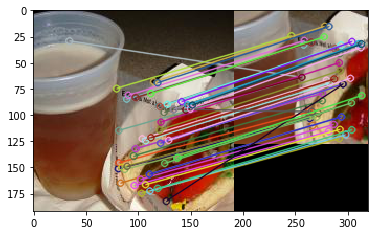

In [11]:
data_loader=data_loader_MSCOCO('val')
total_lose=0
cornner_error_list_coco=[]


count_sub=0
for i in range(6000):
    input_img,u_list_gt,v_list_gt,template_img=data_loader.data_read_batch(1)
    if i==2:
        img_1=np.squeeze(input_img)
        img_2=np.squeeze(template_img)

        sift = cv2.xfeatures2d.SIFT_create()

        # find the keypoints and descriptors with SIFT
        img_1_8bit = cv2.normalize(img_1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        img_2_8bit = cv2.normalize(img_2[:,:,:3], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')


        kp1, des1 = sift.detectAndCompute(img_1_8bit,None)
        kp2, des2 = sift.detectAndCompute(img_2_8bit,None)

        # BFMatcher with default params
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,des2, k=2)

        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])

        # cv2.drawMatchesKnn expects list of lists as matches.
        img3 = cv2.drawMatchesKnn(img_1_8bit,kp1,img_2_8bit,kp2,good,None,flags=2)

        plt.imshow(img3),plt.show()
        break

850


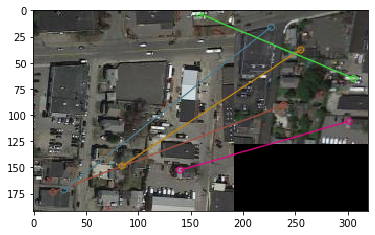

In [19]:
data_loader=data_loader_GoogleEarth('val')
total_lose=0
cornner_error_list_coco=[]


count_sub=0
for i in range(6000):
    input_img,u_list_gt,v_list_gt,template_img=data_loader.data_read_batch(1)
    if i==79:
        
        img_1=np.squeeze(input_img)
        img_2=np.squeeze(template_img)

        sift = cv2.xfeatures2d.SIFT_create()

        # find the keypoints and descriptors with SIFT
        img_1_8bit = cv2.normalize(img_1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        img_2_8bit = cv2.normalize(img_2[:,:,:3], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')


        kp1, des1 = sift.detectAndCompute(img_1_8bit,None)
        kp2, des2 = sift.detectAndCompute(img_2_8bit,None)

        # BFMatcher with default params
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,des2, k=2)

        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])

        # cv2.drawMatchesKnn expects list of lists as matches.
        img3 = cv2.drawMatchesKnn(img_1_8bit,kp1,img_2_8bit,kp2,good,None,flags=2)

        plt.imshow(img3),plt.show()
        break

888


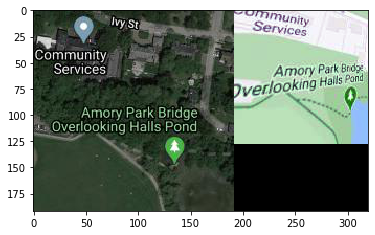

In [22]:
data_loader=data_loader_GoogleMap('val')
total_lose=0
cornner_error_list_coco=[]


count_sub=0
for i in range(6000):
    input_img,u_list_gt,v_list_gt,template_img=data_loader.data_read_batch(1)
    if i==90:
        
        img_1=np.squeeze(input_img)
        img_2=np.squeeze(template_img)

        sift = cv2.xfeatures2d.SIFT_create()

        # find the keypoints and descriptors with SIFT
        img_1_8bit = cv2.normalize(img_1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        img_2_8bit = cv2.normalize(img_2[:,:,:3], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')


        kp1, des1 = sift.detectAndCompute(img_1_8bit,None)
        kp2, des2 = sift.detectAndCompute(img_2_8bit,None)

        # BFMatcher with default params
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,des2, k=2)

        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])

        # cv2.drawMatchesKnn expects list of lists as matches.
        img3 = cv2.drawMatchesKnn(img_1_8bit,kp1,img_2_8bit,kp2,good,None,flags=2)

        plt.imshow(img3),plt.show()
        break